<a href="https://colab.research.google.com/github/matiasmartineza/VITAPRO/blob/main/Emisario_REV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import math
import matplotlib.pyplot as plt
import math
from scipy.optimize import newton
import numpy as np
import pandas as pd
from tabulate import tabulate


#Selección de diámetro según criterio de velocidad

In [11]:
def calcular_velocidad_fluido(caudal, diam_ext, espesor, porcentaje_aire):
    """
    Esta función calcula la velocidad del fluido en una tubería de HDPE PE100.

    Parámetros:
    caudal (float): Caudal en m3/h.
    diam_ext (float): Diámetro externo de la tubería en mm.
    espesor (float): Espesor de la tubería en mm.
    porcentaje_aire (float): Porcentaje de aire en la tubería.

    Retorna:
    velocidad (float): Velocidad del fluido en m/s.
    """
    # Convertimos el caudal de m3/h a m3/s
    caudal_m3s = caudal / 3600

    # Convertimos las medidas de mm a m
    diam_ext_m = diam_ext / 1000
    espesor_m = espesor / 1000

    # Calculamos el diámetro interno de la tubería
    diam_int_m = diam_ext_m - 2 * espesor_m

    # Calculamos el área de la sección transversal de la tubería
    area_m2 = math.pi * (diam_int_m / 2) ** 2

    # Ajustamos el área según el porcentaje de aire en la tubería
    area_ajustada_m2 = area_m2 * (1 - porcentaje_aire / 100)

    # Calculamos la velocidad del fluido en la tubería
    velocidad = caudal_m3s / area_ajustada_m2

    return velocidad

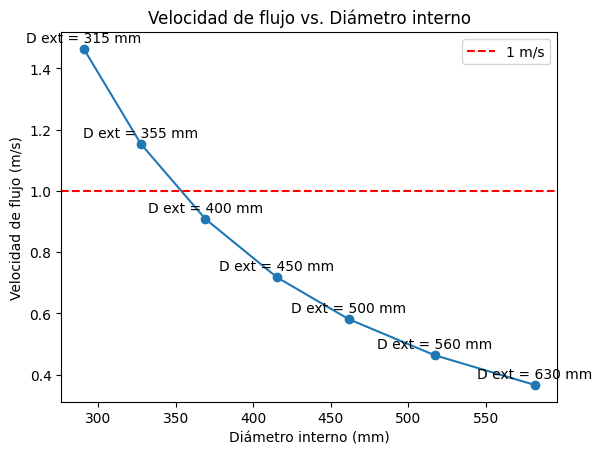

In [12]:
# Parámetros fijos
caudal = 560/2  # m3/h
porcentaje_aire = 20  # % de aire

# Lista de tuberías con diámetros externos y espesores (SDR 26)
tuberias = [
    {"d_ext": 315, "espesor": 12.1},
    {"d_ext": 355, "espesor": 13.7},
    {"d_ext": 400, "espesor": 15.4},
    {"d_ext": 450, "espesor": 17.3},
    {"d_ext": 500, "espesor": 19.2},
    {"d_ext": 560, "espesor": 21.5},
    {"d_ext": 630, "espesor": 24.2},
]

# Calcular las velocidades de flujo y diámetros internos
velocidades = []
diametros_internos = []

for tuberia in tuberias:
    d_ext = tuberia["d_ext"]
    espesor = tuberia["espesor"]
    velocidad = calcular_velocidad_fluido(caudal, d_ext, espesor, porcentaje_aire)
    diam_int = d_ext - 2 * espesor

    velocidades.append(velocidad)
    diametros_internos.append(diam_int)

# Graficar la velocidad de flujo en función del diámetro interno de la tubería
plt.plot(diametros_internos, velocidades, marker='o', linestyle='-')
plt.xlabel('Diámetro interno (mm)')
plt.ylabel('Velocidad de flujo (m/s)')
plt.title('Velocidad de flujo vs. Diámetro interno')

# Etiquetar los puntos en el gráfico con los diámetros externos
for d_ext, d_int, vel in zip([t["d_ext"] for t in tuberias], diametros_internos, velocidades):
    plt.annotate(
        f"D ext = {d_ext} mm",
        (d_int, vel),
        textcoords="offset points",
        xytext=(0, 5),
        ha='center',
    )

# Agregar una línea horizontal a la altura de 1 m/s
plt.axhline(y=1, color='r', linestyle='--', label='1 m/s')
plt.legend()

# Mostrar el gráfico
plt.show()


#Pérdidas de energía en Emisario

##Integración de fracción de aire al modelo para cálculo de viscosidad equivalente

In [13]:
rho_agua = 1000  # kg/m^3
mu_agua = 1.0e-3  # kg/m s
fraccion_aire = porcentaje_aire / 100

rho_efectiva, mu_efectiva = rho_agua, mu_agua

nu = mu_efectiva / rho_efectiva

##Definición de datos

In [24]:
# Datos de entrada
tuberia_seleccionada = {"d_ext": 355, "espesor": 13.6}
#tuberia_seleccionada = {"d_ext": 400, "espesor": 15.3}

caudal = 560/2  # m3/h
L = 254.14  # Longitud de la tubería (m)
k_s = 0.0001 * 1.2  # Rugosidad absoluta de la tubería (m), un valor típico para HDPE

# Datos de vector pérdidas locales
coef_entrada = 0.5  # Coeficiente de entrada (entrada redondeada)
coef_descarga = 1.0  # Coeficiente de descarga
coef_codo_90 = 0.9  # Coeficiente para codos de 90 grados de radio largo

# Crear el vector de pérdidas de carga
singularidades = np.array([coef_entrada, coef_codo_90, coef_codo_90, coef_descarga])

##Cálculo de pérdidas de carga

In [25]:
def colebrook_white(f, Re, k_s, D):
    return 1 / math.sqrt(f) + 2 * math.log10( (k_s / (3.7 * D)) + (2.51 / (Re * math.sqrt(f))) )

def calcular_perdida_carga(v, D, L, k_s, nu, g=9.81):
    # Calcular el número de Reynolds
    Re = (v * D) / nu

    # Resolver la ecuación de Colebrook-White para el coeficiente de fricción de Darcy (f)
    f_initial_guess = 0.02
    f = newton(colebrook_white, f_initial_guess, args=(Re, k_s, D))
    print(f)

    # Calcular la pérdida de carga usando la fórmula de Darcy-Weisbach
    h_L = f * (L / D) * (v ** 2) / (2 * g)

    return h_L

def calcular_perdida_carga_total(v, D, L, k_s, nu, singularidades, g=9.81):
    # Calcular la pérdida de carga principal
    h_L = calcular_perdida_carga(v, D, L, k_s, nu, g)

    # Calcular las pérdidas de carga locales por singularidades
    h_L_singularidades = sum(K * (v ** 2) / (2 * g) for K in singularidades)

    # Calcular la pérdida de carga total
    h_L_total = h_L + h_L_singularidades

    return h_L_total

# Calcular la velocidad del fluido
velocidad = calcular_velocidad_fluido(caudal, tuberia_seleccionada["d_ext"], tuberia_seleccionada["espesor"], porcentaje_aire)

# Calcular el diámetro interno de la tubería en metros
d_int_m = (tuberia_seleccionada["d_ext"] - 2 * tuberia_seleccionada["espesor"]) / 1000

# Calcular la pérdida de carga total
h_L_total = calcular_perdida_carga_total(velocidad, d_int_m, L, k_s, nu, singularidades)

# Imprimir la pérdida de carga total
print(f"La pérdida de carga total en el emisario submarino es de {h_L_total:.2f} metros.")

0.017091526119813554
La pérdida de carga total en el emisario submarino es de 1.12 metros.


In [26]:
import pandas as pd
from tabulate import tabulate

def datos_tuberia(d_ext, espesor, caudal, porcentaje_aire, L, k_s, nu):
    velocidad = calcular_velocidad_fluido(caudal, d_ext, espesor, porcentaje_aire)
    d_int_m = (d_ext - 2 * espesor) / 1000
    Re = (velocidad * d_int_m) / nu

    f_initial_guess = 0.02
    f = newton(colebrook_white, f_initial_guess, args=(Re, k_s, d_int_m))
    h_L = calcular_perdida_carga(velocidad, d_int_m, L, k_s, nu)
    h_L_total = calcular_perdida_carga_total(velocidad, d_int_m, L, k_s, nu, singularidades)

    return {
        "d_int_m": d_int_m,
        "caudal": caudal,
        "velocidad": velocidad,
        "Re": Re,
        "k_s": k_s,
        "f": f,
        "L": L,
        "h_L": h_L,
        "h_L_total": h_L_total - h_L,
        "h_Lt": h_L_total
    }

def datos_fittings():
    return [
        {"elemento": "Entrada redondeada", "cantidad": 1, "K": coef_entrada},
        {"elemento": "Codo 90°", "cantidad": 2, "K": coef_codo_90},
        {"elemento": "Descarga", "cantidad": 1, "K": coef_descarga},
    ]

def mostrar_tablas(tuberia_seleccionada, caudal, porcentaje_aire, L, k_s, nu):
    # Crear el DataFrame de datos de tubería
    datos = datos_tuberia(tuberia_seleccionada["d_ext"], tuberia_seleccionada["espesor"], caudal, porcentaje_aire, L, k_s, nu)
    datos_redondeados = {key: round(value, 4) for key, value in datos.items()}
    df_tuberia = pd.DataFrame([datos_redondeados])

    # Renombrar las columnas y agregar unidades de medida
    columnas_profesionales = {
        "d_int_m": "Diámetro\ninterno (m)",
        "caudal": "Caudal\n(m³/h)",
        "velocidad": "Velocidad\n(m/s)",
        "Re": "Número de\nReynolds",
        "k_s": "Rugosidad\nabsoluta (m)",
        "f": "Factor de\nfricción",
        "L": "Longitud de\nla tubería (m)",
        "h_L": "Pérdidas mayores\nde carga (m)",
        "h_L_total": "Pérdidas de carga\nsingularidades (m)",
        "h_Lt": "Pérdidas de carga\ntotales (m)"
    }
    df_tuberia.rename(columns=columnas_profesionales, inplace=True)

    # Crear el DataFrame de datos de fittings
    df_fittings = pd.DataFrame(datos_fittings())

    # Renombrar las columnas y agregar unidades de medida
    columnas_fittings_profesionales = {
        "elemento": "Elemento",
        "cantidad": "Cantidad",
        "K": "Coeficiente K",
    }
    df_fittings.rename(columns=columnas_fittings_profesionales, inplace=True)

    # Mostrar las tablas con tabulate
    print("Tabla de datos de tubería:\n")
    print(tabulate(df_tuberia, headers="keys", tablefmt="pretty"))
    print("\nTabla de datos de fittings:\n")
    print(tabulate(df_fittings, headers="keys", tablefmt="pretty"))

# Ejemplo de uso de la función mostrar_tablas
mostrar_tablas(tuberia_seleccionada, caudal, porcentaje_aire, L, k_s, nu)


0.017091526119813554
0.017091526119813554
Tabla de datos de tubería:

+---+-------------+--------+-----------+-------------+--------------+-----------+----------------+------------------+--------------------+-------------------+
|   |  Diámetro   | Caudal | Velocidad |  Número de  |  Rugosidad   | Factor de |  Longitud de   | Pérdidas mayores | Pérdidas de carga  | Pérdidas de carga |
|   | interno (m) | (m³/h) |   (m/s)   |  Reynolds   | absoluta (m) | fricción  | la tubería (m) |   de carga (m)   | singularidades (m) |    totales (m)    |
+---+-------------+--------+-----------+-------------+--------------+-----------+----------------+------------------+--------------------+-------------------+
| 0 |   0.3278    | 280.0  |   1.152   | 377630.1951 |    0.0001    |  0.0171   |     254.14     |      0.8963      |       0.2232       |      1.1195       |
+---+-------------+--------+-----------+-------------+--------------+-----------+----------------+------------------+------------------

##Evaluación de energía del sistema

In [27]:
def comparar_energias(h_disp, h_perdida, h_profundidad, rho_emisario, rho_mar, g=9.81):
    """
    Esta función compara la energía disponible con la energía necesaria para que el agua llegue a la
    salida del emisario, teniendo en cuenta las pérdidas de energía y la diferencia de cota entre la
    marea más alta y la salida del emisario. También considera las densidades del fluido que transporta
    el emisario y el agua de mar del cuerpo receptor.

    Parámetros:
    h_disp (float): Altura disponible desde la salida del emisario de la planta de tratamiento hasta
                    la cota de marea más alta (m).
    h_perdida (float): Pérdida de carga total en el emisario submarino (m).
    h_profundidad (float): Diferencia de cota desde la marea más alta hasta la desembocadura del emisario (m).
    rho_emisario (float): Densidad del fluido que transporta el emisario (kg/m³).
    rho_mar (float): Densidad del agua de mar del cuerpo receptor (kg/m³).
    g (float): Aceleración de la gravedad (m/s²). Por defecto es 9.81 m/s².

    Retorna:
    delta_energia (float): La diferencia entre la energía disponible y la energía necesaria para el transporte.
                          Si es positiva, el transporte se puede llevar a cabo. Si es negativa, es porque falta energía.
    """
    # Calcular la energía disponible
    energia_disponible = (h_disp + h_profundidad) * rho_emisario * g

    # Calcular la energía necesaria para superar las pérdidas de energía y alcanzar la salida del emisario
    energia_necesaria = h_perdida * rho_emisario * g + h_profundidad * rho_mar * g

    # Comparar las energías
    return energia_disponible - energia_necesaria

# Ejemplo de uso de la función comparar_energias
altura_disp = 2.86 # m
rho_mar = 1025  # kg/m³ (estimación)
h_profundidad = 27.46 # m

#resultado = comparar_energias(altura_disp, h_L_total, h_profundidad, rho_efectiva, rho_mar)
resultado = comparar_energias(altura_disp, h_L_total, h_profundidad, 1000, rho_mar)
print('delta_energia =', resultado / (9.81 * 1000), ' m')


delta_energia = 1.0539647481416172  m


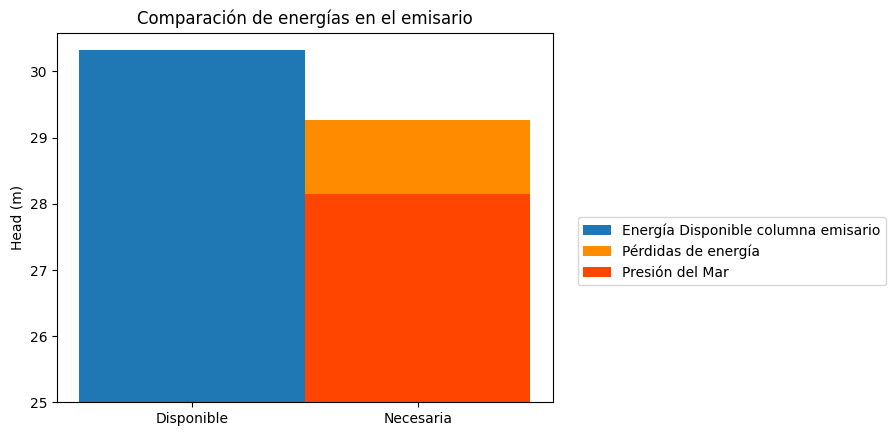

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_energy_levels(altura_disp, h_L_total, h_profundidad, rho_emisario, rho_mar):
    energia_disponible = (altura_disp + h_profundidad) * 1000 * 9.81
    energia_mar = h_profundidad * rho_mar * 9.81
    energia_perdida = h_L_total * 1000 * 9.81

    fig, ax = plt.subplots()

    barWidth = 0.2
    r1 = np.arange(1)
    r2 = [x + barWidth for x in r1]

    offset = 25 * 1000 * 9.81  # Offset de 25 m
    plt.bar(r1, (energia_disponible - offset) / 9810, width=barWidth, label='Energía Disponible columna emisario', bottom=offset / 9810)
    plt.bar(r2, (energia_perdida + energia_mar - offset) / 9810, width=barWidth, label='Pérdidas de energía', color='darkorange', bottom=offset / 9810)
    plt.bar(r2, (energia_mar - offset) / 9810, width=barWidth, label='Presión del Mar', color='orangered', bottom=offset / 9810)

    plt.ylabel('Head (m)')
    plt.title('Comparación de energías en el emisario')
    plt.xticks([r1[0], r2[0]], ['Disponible', 'Necesaria'])

    # Calcular y mostrar la diferencia de altura entre las barras
    delta_altura = ((energia_disponible - energia_perdida - energia_mar) / 9810)

    # Posicionar las etiquetas a la derecha del gráfico
    ax.annotate(f'Diferencia = {delta_altura:.2f} m', xy=(1, h_profundidad + altura_disp), xytext=(1.1, h_profundidad + altura_disp),
                fontsize=10, verticalalignment='center')

    # Mover la leyenda a la derecha del gráfico
    plt.legend(bbox_to_anchor=(1.05, .5), loc='upper left', borderaxespad=0.)

    plt.show()

plot_energy_levels(altura_disp, h_L_total, h_profundidad, rho_efectiva, rho_mar)


#Evaluación estructural

##Cálculo de Peso y Empuje

In [ ]:
import math
import numpy as np

sdr = np.array([41, 32.5, 26, 21, 19, 17, 11])
resistencias = np.array([2.8, 3.6, 4.5, 5.6, 6.3, 7.0, 11.2]) * 98066.5

In [ ]:
# Constantes
DENSIDAD_HDPE = 950
DENSIDAD_AGUA = 1000
DENSIDAD_AGUA_MAR = 1025
DENSIDAD_AIRE = 1.29


DIAMETRO_EXT = tuberia_seleccionada["d_ext"] / 1000.
ESPESOR = tuberia_seleccionada["espesor"] / 1000.

porcentaje_aire = 20
def peso_tubo(diametro_exterior, espesor, densidad_hdpe, densidad_aire, densidad_agua, densidad_agua_mar, porcentaje_aire):
    radio_exterior = diametro_exterior / 2
    radio_interior = radio_exterior - espesor
    volumen_exterior = math.pi * radio_exterior**2
    volumen_interior = math.pi * radio_interior**2
    volumen_tubo = volumen_exterior - volumen_interior
    masa = volumen_tubo * (densidad_hdpe) + volumen_interior * porcentaje_aire * densidad_aire / 100. + volumen_interior * (100. - porcentaje_aire) * densidad_agua / 100.
    return masa * 9.81

def empuje_agua_mar(diametro_exterior, espesor, densidad_agua_mar):
    radio_exterior = diametro_exterior / 2
    volumen_exterior = math.pi * radio_exterior**2
    empuje = volumen_exterior * densidad_agua_mar
    return empuje * 9.81

# Calcular peso y empuje
peso_total = peso_tubo(DIAMETRO_EXT, ESPESOR, DENSIDAD_HDPE, DENSIDAD_AIRE, DENSIDAD_AGUA, DENSIDAD_AGUA_MAR, porcentaje_aire)
empuje = empuje_agua_mar(DIAMETRO_EXT, ESPESOR, DENSIDAD_AGUA_MAR)

print(f"Peso del tubo: {peso_total:.2f} N/m")
print(f"Empuje ejercido por el agua de mar: {empuje:.2f} N/m")

Peso del tubo: 798.47 N/m
Empuje ejercido por el agua de mar: 995.27 N/m


## Cálculo de Sustentación y Arrastre

In [ ]:
def lift_drag_wave(Hwave, Twave, Vwind, Vc, fref, CL_wave, CD_wave, rho_sw, g, De, Ae):
    Lwave = (g * Twave**2) / (2 * math.pi)
    FD_wave = (CD_wave * fref**2 * rho_sw * g * Ae * Hwave**2) / (Lwave * De)
    FL_wave = (CL_wave * fref**2 * rho_sw * g * Ae * Hwave**2) / (Lwave * De)
    return FL_wave, FD_wave

def lift_drag_current(Vc, CL_c, CD_c, rho_sw, g, De):
    FL_c = 0.5 * CL_c * rho_sw * Vc**2 * De
    FD_c = 0.5 * CD_c * rho_sw * Vc**2 * De
    return FL_c, FD_c

Hwave = 3 # Altura de la ola en m
Twave = 14 # Periodo de la ola en s
Vwind = 20 # Velocidad del ciento en m/s
fref = 0.9 # Coeficiente de refracción adimensional
CL_wave = 1.5 #Coeficiente de sustentación debido al oleaje
CD_wave = 1.0 #Coeficiente de arrastre debijo al oleaje

Vc = 0.4 # Velocidad de la corriente en m/s
CL_c = 1.5 #Coeficiente de sustentación debido a la corriente
CD_c = 1.2 #Coeficiente de arrastre debijo a la corriente

De = DIAMETRO_EXT
Ae = (De ** 2) * math.pi / 4.0

# Calcular lift y drag para oleaje y corriente marina
lift_w, drag_w = lift_drag_wave(Hwave, Twave, Vwind, Vc, fref, CL_wave, CD_wave, DENSIDAD_AGUA_MAR, 9.81, De, Ae)
lift_c, drag_c = lift_drag_current(Vc, CL_c, CD_c, DENSIDAD_AGUA_MAR, 9.81, De)

drag = drag_w + drag_c
lift = lift_w + lift_c

import pandas as pd
from tabulate import tabulate

# Parámetros de entrada
input_params = {
    'Parámetro': ['Altura de la ola', 'Periodo de la ola', 'Velocidad del viento', 'Coeficiente de refracción',
                  'Coef. de sustentación oleaje', 'Coef. de arrastre oleaje', 'Velocidad de corriente',
                  'Coef. de sustentación corriente', 'Coef. de arrastre corriente', 'Diámetro exterior',
                  'Área efectiva'],
    'Unidad': ['m', 's', 'm/s', '-', '-', '-', 'm/s', '-',
               '-', 'm', 'm^2'],
    'Valor': [Hwave, Twave, Vwind, fref, CL_wave, CD_wave, Vc, CL_c, CD_c, De, Ae]
}

input_df = pd.DataFrame(input_params)

# Resultados
results = {
    'Fuerza de\nsustentación oleaje\n(N/m)': [lift_w],
    'Fuerza de\narrastre oleaje\n(N/m)': [drag_w],
    'Fuerza de\nsustentación corriente\n(N/m)': [lift_c],
    'Fuerza de\narrastre corriente\n(N/m)': [drag_c],
    'Fuerza de\nsustentación total\n(N/m)': [lift],
    'Fuerza de\narrastre total\n(N/m)': [drag]
}

results_df = pd.DataFrame(results)

# Imprimir las tablas
print("Parámetros de entrada:")
print(tabulate(input_df, headers='keys', tablefmt='psql', showindex=False))

print("\nResultados:")
print(tabulate(results_df, headers='keys', tablefmt='psql', showindex=False))

Parámetros de entrada:
+---------------------------------+----------+------------+
| Parámetro                       | Unidad   |      Valor |
|---------------------------------+----------+------------|
| Altura de la ola                | m        |  3         |
| Periodo de la ola               | s        | 14         |
| Velocidad del viento            | m/s      | 20         |
| Coeficiente de refracción       | -        |  0.9       |
| Coef. de sustentación oleaje    | -        |  1.5       |
| Coef. de arrastre oleaje        | -        |  1         |
| Velocidad de corriente          | m/s      |  0.4       |
| Coef. de sustentación corriente | -        |  1.5       |
| Coef. de arrastre corriente     | -        |  1.2       |
| Diámetro exterior               | m        |  0.355     |
| Área efectiva                   | m^2      |  0.0989798 |
+---------------------------------+----------+------------+

Resultados:
+-----------------------+-------------------+-------------------

##Evaluación Estructural tubería y distanciamiento de fondeos

In [ ]:
def modulo_inercia(diametro_exterior, espesor):
    radio_exterior = diametro_exterior / 2
    radio_interior = radio_exterior - espesor
    I = (math.pi / 4) * (radio_exterior**4 - radio_interior**4)
    return I

# Constantes
E = 1.4E9  # Módulo de elasticidad en Pa

# Calcular la carga distribuida resultante
carga_distribuida = math.sqrt((peso_total - lift - empuje) ** 2 + drag ** 2)
print(f"Carga distribuida resultante: {carga_distribuida:.2f} N/m")

# Calcular el momento flector máximo para una viga empotrada
distancia_entre_fondeos = 5.5  # m
momento_flector_max = carga_distribuida * distancia_entre_fondeos**2 / 12.0
print(f"Momento flector máximo: {momento_flector_max:.2f} Nm")

# Calcular el módulo de inercia (I)
I = modulo_inercia(DIAMETRO_EXT, ESPESOR)
print(f"Módulo de inercia: {I:.2e} m^4")

# Calcular la deformación máxima en la viga empotrada
deformacion_max = carga_distribuida * distancia_entre_fondeos**4 / (384 * E * I)
print(f"Deformación máxima: {deformacion_max:.2e} m")

# Calcular porcentaje de deformación
deformacion_max = carga_distribuida * distancia_entre_fondeos**4 / (384 * E * I)
porcentaje_def = 100 * deformacion_max / DIAMETRO_EXT
print(f"Porcentaje de deformacion: {porcentaje_def * 100:.3f} %")


Carga distribuida resultante: 355.50 N/m
Momento flector máximo: 896.17 Nm
Módulo de inercia: 2.13e-04 m^4
Deformación máxima: 2.84e-03 m
Porcentaje de deformacion: 0.801 %


In [ ]:
#EVALUACION

DIAMETRO_EXT = .355 #m3
porcentaje_aire = 20 #%

def evaluacion(i, l, DIAMETRO_EXT, porcentaje_aire):
    ESPESOR = DIAMETRO_EXT / sdr[i]

    peso_total = peso_tubo(DIAMETRO_EXT, ESPESOR, DENSIDAD_HDPE, DENSIDAD_AIRE, DENSIDAD_AGUA, DENSIDAD_AGUA_MAR, porcentaje_aire)
    empuje = empuje_agua_mar(DIAMETRO_EXT, ESPESOR, DENSIDAD_AGUA_MAR)
    lift_w, drag_w = lift_drag_wave(Hwave, Twave, Vwind, Vc, fref, CL_wave, CD_wave, DENSIDAD_AGUA_MAR, 9.81, DIAMETRO_EXT, Ae)
    lift_c, drag_c = lift_drag_current(Vc, CL_c, CD_c, DENSIDAD_AGUA_MAR, 9.81, DIAMETRO_EXT)

    drag = drag_w + drag_c
    lift = lift_w + lift_c

    # Constantes
    E = 1.4E9  # Módulo de elasticidad en Pa

    # Calcular la carga distribuida resultante (N/m)
    carga_distribuida = math.sqrt((peso_total - lift - empuje) ** 2 + drag ** 2)

    # Calcular el módulo de inercia I (m4)
    I = modulo_inercia(DIAMETRO_EXT, ESPESOR)

    # Calcular el momento flector máximo para una viga empotrada (Nm)
    momento_flector_max = carga_distribuida * l**2 / 12.0

    # Calcular porcentaje de deformación
    deformacion_max = carga_distribuida * distancia_entre_fondeos**4 / (384 * E * I)
    porcentaje_def = 100 * deformacion_max / DIAMETRO_EXT

    return(porcentaje_def)

print(evaluacion(2, 5.5, DIAMETRO_EXT, porcentaje_aire))

0.7978448035598638
